In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook',palette='deep')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


#keras
from keras.utils.np_utils import to_categorical#one hot encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [44]:
import random
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ["PYTHONHASHEED"] = str(seed_value)
    
SEED=42
set_seed(SEED)

In [23]:
train=pd.read_csv("../input/digit-recognizer/train.csv")
test=pd.read_csv("../input/digit-recognizer/test.csv")

In [24]:
print("Train shape:",train.shape)
train.sample(3)

Train shape: (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41526,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2534,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
ytrain=train["label"]
xtrain=train.drop(columns="label")

In [26]:
xtrain.sample(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
38575,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
343,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


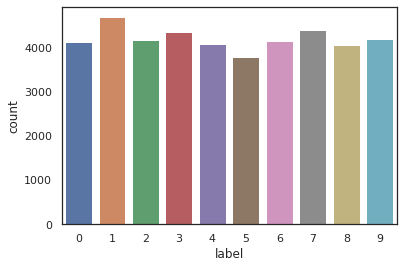

In [27]:
sns.countplot(ytrain)

In [28]:
xtrain.isnull().any().describe() #there is no missing values inside

count       784
unique        1
top       False
freq        784
dtype: object

In [29]:
#normalization
xtrain=xtrain/255.
test=test/255.

In [38]:
#Reshape kerasは(サンプル数、縦、横、チャンネル数(MNISTは灰色だから1))
xtrain = xtrain.reshape(-1,28,28,1)
test = test.reshape(-1,28,28,1)

print(xtrain.shape)

(42000, 28, 28, 1)


In [40]:
#Label encoding 例えば、もしラベルが2ならば[0,0,1,0,0,0,0,0,0,0]
ytrain=to_categorical(ytrain,num_classes=10)

In [47]:
#trainとvalidationに分ける
xtrain,xval,ytrain,yval=train_test_split(xtrain,ytrain,test_size=0.2, random_state=SEED)

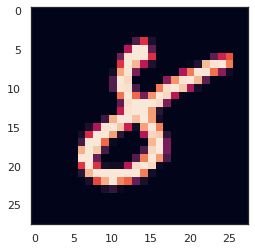

In [49]:
plt.imshow(xtrain[0].reshape(28,28))

In [52]:
model=Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.15))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(10,activation="softmax"))

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        51264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)         

In [54]:
optimizer=Adam(lr=0.001)

In [55]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=["accuracy"])

In [57]:
"""It is better to have a decreasing learning rate during the training to reach
efficinetly the global minimum of the loss function."""

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [59]:
#Fit the model
history=model.fit(xtrain,ytrain,batch_size=64,epochs=30, validation_data=(xval,yval))

Epoch 1/30
420/420 [==============================] - 142s 338ms/step - loss: 0.2222 - accuracy: 0.9305 - val_loss: 0.0652 - val_accuracy: 0.9786
Epoch 2/30
420/420 [==============================] - 137s 325ms/step - loss: 0.0639 - accuracy: 0.9804 - val_loss: 0.0523 - val_accuracy: 0.9830
Epoch 3/30
420/420 [==============================] - 141s 335ms/step - loss: 0.0476 - accuracy: 0.9856 - val_loss: 0.0363 - val_accuracy: 0.9888
Epoch 4/30
420/420 [==============================] - 140s 334ms/step - loss: 0.0334 - accuracy: 0.9896 - val_loss: 0.0455 - val_accuracy: 0.9865
Epoch 5/30
420/420 [==============================] - 143s 341ms/step - loss: 0.0301 - accuracy: 0.9903 - val_loss: 0.0339 - val_accuracy: 0.9903
Epoch 6/30
420/420 [==============================] - 137s 327ms/step - loss: 0.0252 - accuracy: 0.9919 - val_loss: 0.0340 - val_accuracy: 0.9900
Epoch 7/30
420/420 [==============================] - 137s 326ms/step - loss: 0.0236 - accuracy: 0.9924 - val_loss: 0.0291 -

In [61]:
epochs=30

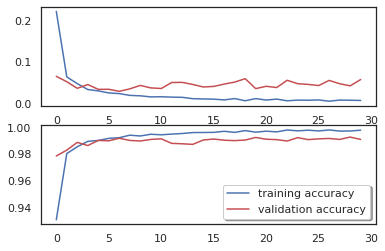

In [64]:
#Evaluate the model

fig,ax=plt.subplots(2,1)
ax[0].plot(range(epochs),history.history['loss'],color='b',label="training loss")
ax[0].plot(range(epochs), history.history['val_loss'],color='r',label="validation loss")

ax[1].plot(range(epochs),history.history['accuracy'],color='b',label="training accuracy")
ax[1].plot(range(epochs), history.history['val_accuracy'],color='r',label="validation accuracy")

legend=ax[1].legend(loc="best", shadow=True)

In [72]:
#confusion matrix confusion matrix can be very helpful to see your model drawbacks
import itertools

def plot_confusion_matrix(cm, classes, normalization=False,title="Confusion matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest",cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks= np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalization:
        cm=cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
        
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [73]:
ypred=model.predict(xval)

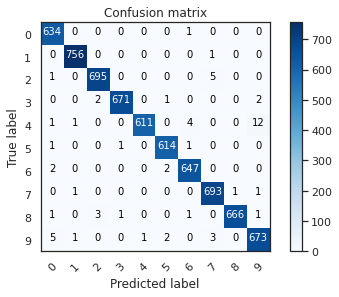

In [74]:
ypred_classes=np.argmax(ypred,axis=1)#Convert to one hot vector
ytrue=np.argmax(yval,axis=1)

#compute the confusion_matrix
confusion_mtx=confusion_matrix(ytrue,ypred_classes)

plot_confusion_matrix(confusion_mtx,classes=range(10))

In [75]:
preds=model.predict(test)

In [ ]:
preds=np.argmax(preds, axis=1)

In [77]:
output = pd.DataFrame(
    {
        'ImageId':pd.Series(range(1,28001)),
        "Label":preds
    }
)

output.to_csv('my_submission.csv',index=False)
print(output.head())

Exception: Data must be 1-dimensional